In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from src.data_visuals import *
from src.feature_engineering import DataEnhancer

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [7]:
file_path = os.path.join("data", "energydata_complete.csv")
data = pd.read_csv(file_path)

data.date = pd.to_datetime(data.date, format="%d-%m-%Y %H:%M")
data.set_index("date", inplace=True)
data.head(3)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.2,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.2,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.2,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668


# Data exploration

## [Variables](data/variables_info.txt)

All 28 variables in the dataset are continuous, except for "date", which has been set as the index.

The dataset contains:
* General appliances' energy usage (Appliances)
* Lights' energy usage (lights)
* Temperature and relative humidity in 8 rooms: kitchen, living room, office room, bathroom, two beedrooms, laundry room and ironing room, labeled as T1, Rh_1...T9, Rh_9 (excluding T6, RH_6 which represent temperature and humidity outside the house)
* Temperature and relative humidity outside the house (as mentioned above, and also from nearest weather station)
* Other weather data from the weather station (atmospheric pressure, windspeed, visibility, dew point).
* Two random variable (rv1, rv2) which can be used for testing if models provide feature importances correctly

**Example variable distributions are depicted below**:
* T2 and RH_2 are temperature and humidity in the living room, while T5 and RH_5 - in the bathroom
* T_out, Press_mm_hg, Windspeed - data from nearest weather station
* rv1 - random variable

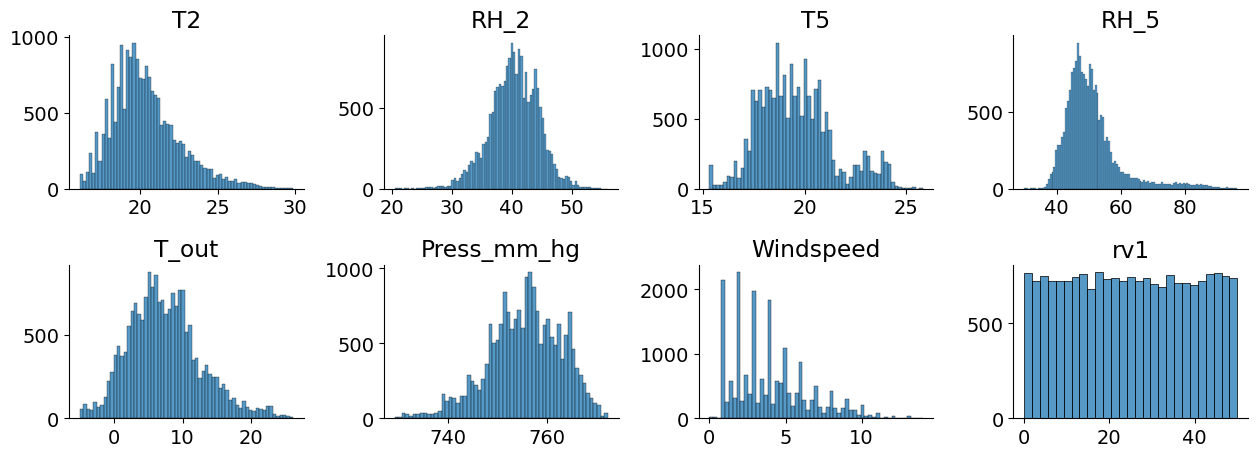

In [4]:
histplots_grid(2, 4, data, features = ["T2", "RH_2", "T5", "RH_5", "T_out", "Press_mm_hg", "Windspeed", "rv1"])

RH_6 contains information about the humidity outside the house, while RH_out provides data from the weather station. The distributions of these two variables can be seen below.

**The values in RH_6 are strange** and significantly differ from those obtained from the weather station, suggesting that a part of the measurement process might have gone wrong. For instance, there are many values at 0 and others less than 25%, which are improbable given the maritime temperate [climate of Belgium](https://en.wikipedia.org/wiki/Belgium#Geography) where such low humidity levels are virtually impossible. Moreover, it was mentioned [1] that the placement of the sensor for this parameter might not had been optimal. In contrast, the values in the RH_out variable appear more reasonable. Due to these discrepancies, it was decided to exclude the RH_6 variable and rely solely on the humidity information from RH_out.

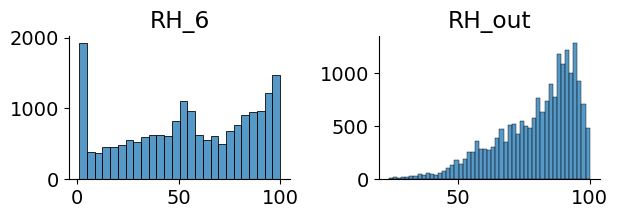

In [5]:
histplots_grid(1, 2, data, features = ["RH_6", "RH_out"])

Some of the variables contain **rare high values** - notably in Windspeed (above), lights, but primarily in Appliances (below). As a result, the time-based features derived from Appliances will exhibit a similar right-skewed distribution. These outlier values will not be removed, as they are assumed to be important for accurate prediction. To address this issue, for models that are sensitive to outliers and data scale, appropriate transformations of the input data will be applied, along with transformations of the target variable. Additionally, high values in Appliances will be flagged with an additional 0/1 column.

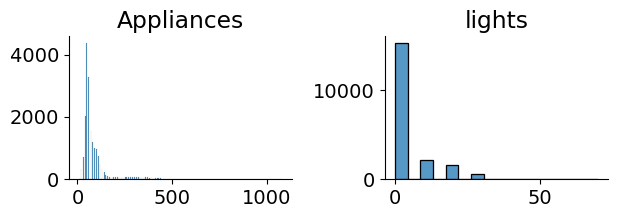

In [6]:
histplots_grid(1, 2, data, features = ["Appliances", "lights"])

## Energy consumption over the entire time period covered by the data

It was verified that **the time differences** in the data are always equal to 10 minutes.

In [8]:
time_diffs = data.index.to_series().diff().dt.total_seconds().div(60)
time_diffs.min(), time_diffs.max()

(10.0, 10.0)

### General view

**In the heatmap below**, an overall view of the daily average energy consumption by devices throughout the entire data period is presented. While it's challenging to identify specific trends from individual days, a pattern emerges in subsequent months with more days of lower consumption. This could suggest that, as the weather becomes warmer over the year, residents might spend less time at home. This trend is also noticeable in the monthly daily means. However, excluding January – which not only lacks data for a full month but also seems to be disrupted by an atypical period of minimal consumption, specifically from January 27-29 – the trend becomes more consistent.

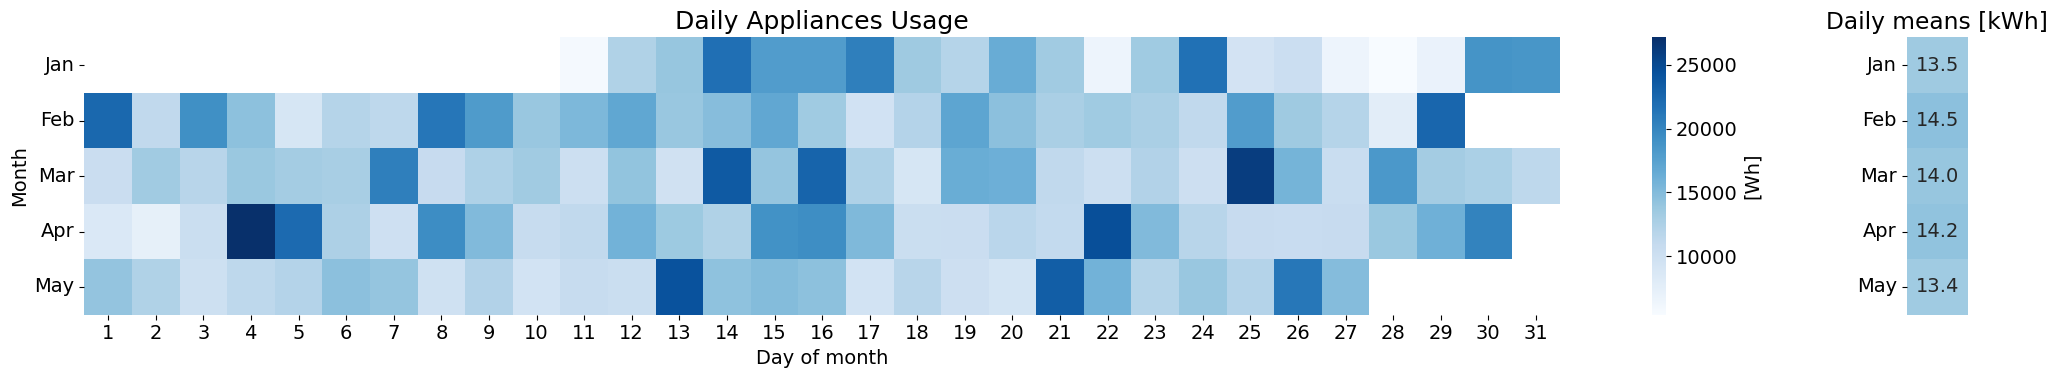

In [9]:
energy_consumption_all_time(data.Appliances)

In **the chart below**, it can be seen that light usage decreases over time, especially from around the end of March. This is associated with the days getting longer at the Belgium's latitude. Additionally, in Belgium, there is a time change at the end of March to save energy.\
It's noteworthy that the data does not reflect the clock change (a 1-hour advancement on the last Sunday of March). Therefore, it is likely that a consistent time standard is used throughout the entire period covered by the data.

Another point to observe is that there are two periods (each 2-3 days long, one of them mentioned above as atypical) where there is no light energy consumption and general consumption is minimal. It is assumed that during these days, the usual daily activities did not occur - probably because **nobody was home**.

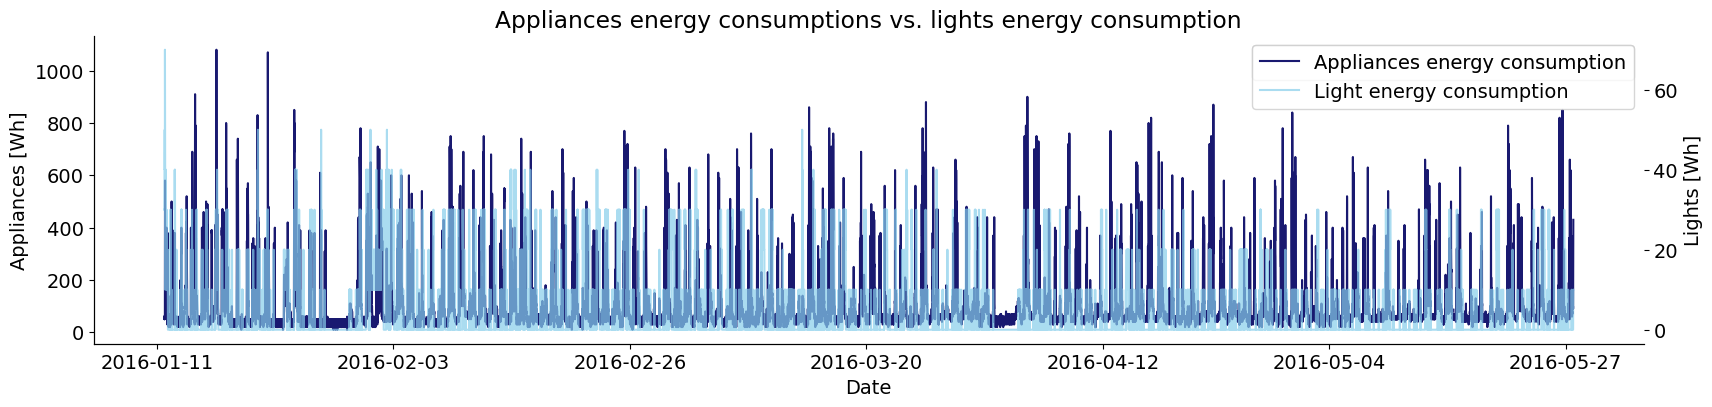

In [4]:
appliances_vs_lights_plot(data.Appliances, data.lights)

### Time series decomposition and autocorrelation

To analyze the components of the time series, an additive model was applied on both daily and weekly periods. The stationarity of the time series was confirmed using the Dickey-Fuller test. To better showcase the trend, the series decomposition was presented after logarithmic transformation due to the wide range of values.

**The daily trend** appears to be variable, with clear peaks and troughs. These patterns may correspond to typical daily routines, such as increased appliance usage in the morning and evening hours. These fluctuations are quite sharp, indicating significant changes in appliance usage over short periods of time.\
**The weekly trend** shows a more smoothed trend compared to the daily one. There are some oscillations that may correspond to differences in appliance usage on different days of the week. The variability of the weekly trend is smaller, suggesting that user behaviors are more predictable over a longer period. However, there are still periods where the trend clearly rises or falls.\
The third chart indicates the presence of **seasonality** in the data, with regular patterns repeating every week. The height of the bars indicates significant differences in appliances usage depending on the day of the week or time. The regularity and predictability of this component can be a positive aspect in building forecasting models, however, the amplitude of the seasonality is significant, suggesting that the weekly factor has a large impact on consumption variability.\
**The residuals** represent irregular fluctuations that were not explained by the trend or seasonality. The chart shows that the residuals are relatively large and quite dispersed. The large variance of residuals could pose a problem for predictive modeling, as it suggests that a significant portion of the variance in the data is irregular and potentially difficult to predict.

Modeling this series may be challenging, as it requires capturing rapid changes. It can also be expected that for effective prediction, it is very important whether additional variables entering the model will explain the fluctuations and residuals described above. Unfortunately, the short period covered by the data increases the impact of periods identified as atypical (e.g., due to the absence of occupants).

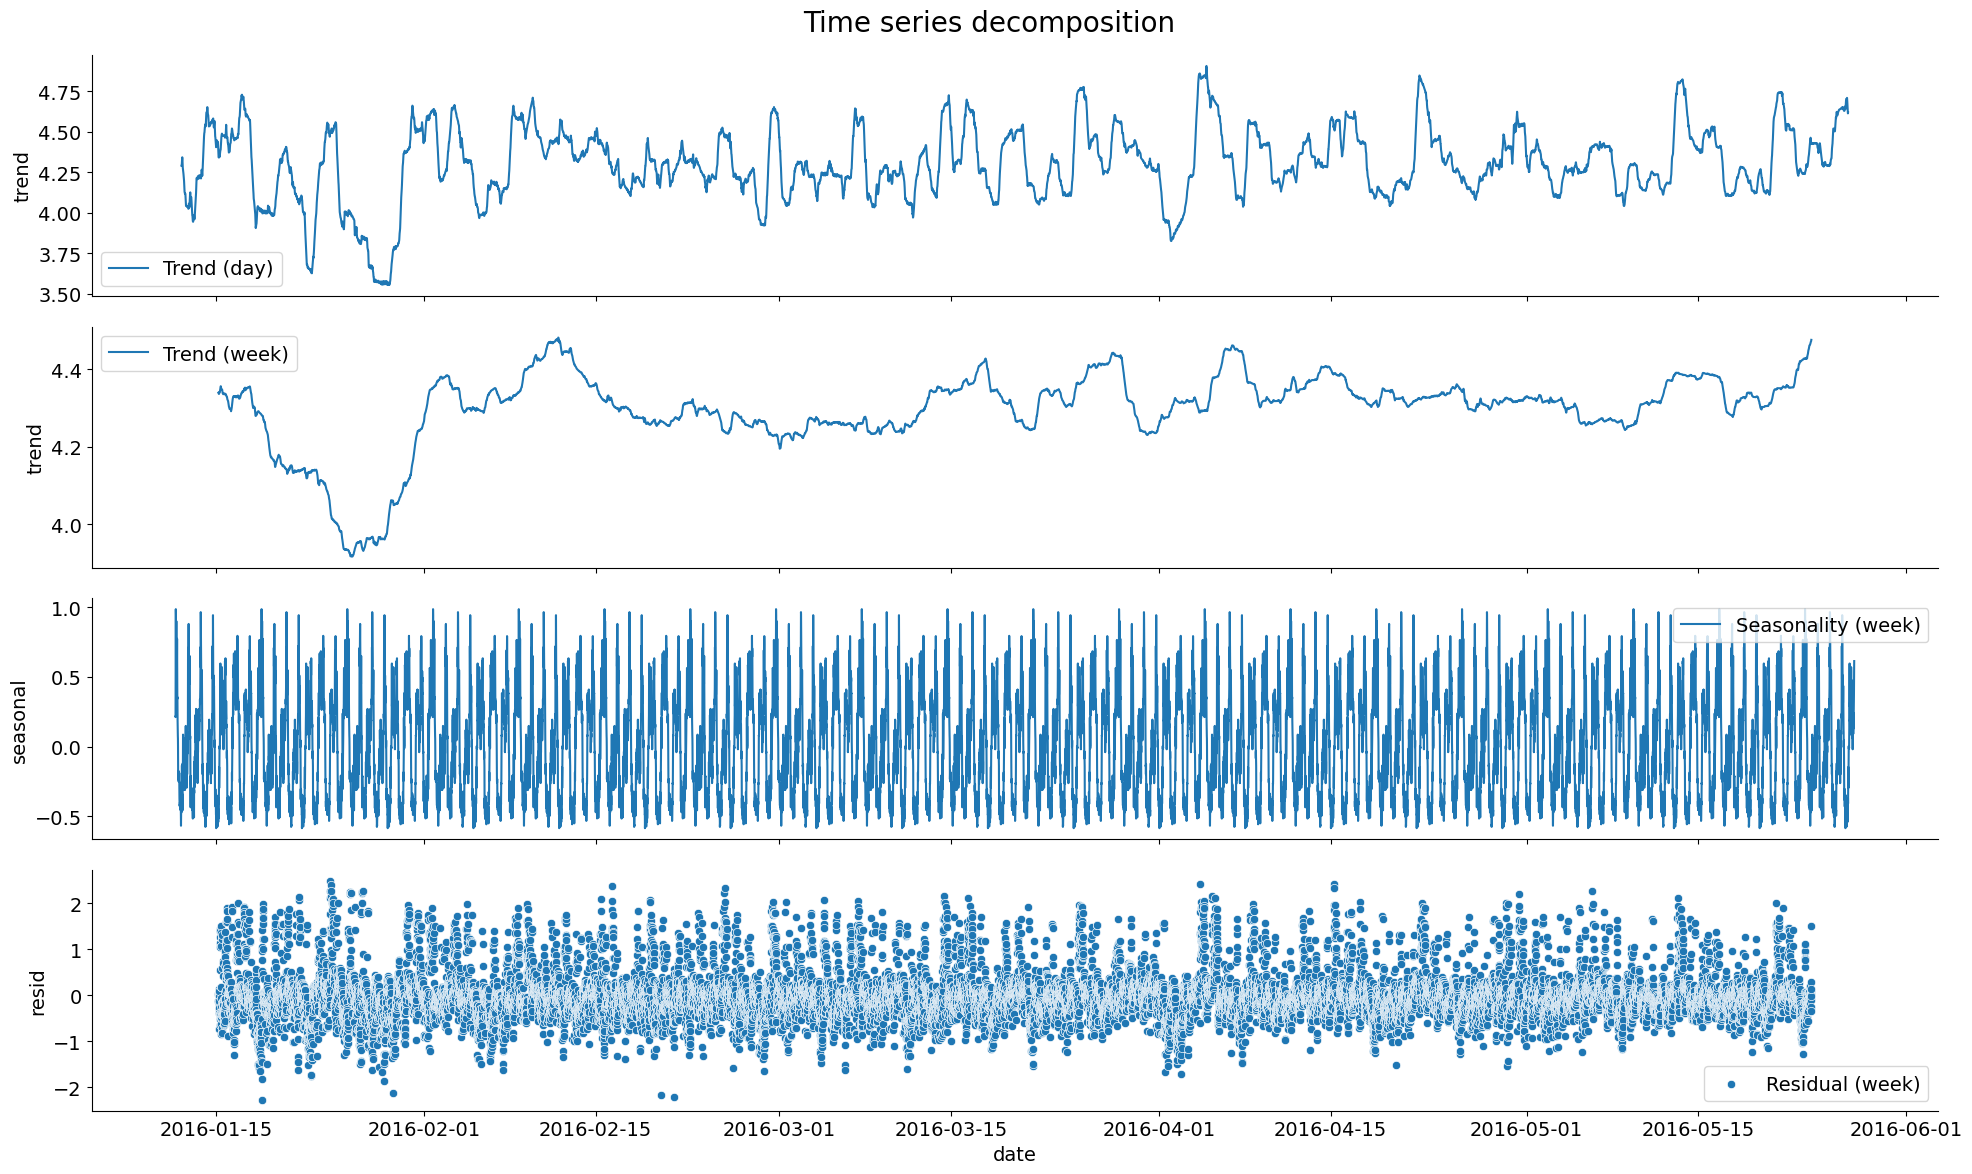

In [23]:
result_by_day = sm.tsa.seasonal_decompose(np.log(data.Appliances), model="additive", period=144)
result_by_week = sm.tsa.seasonal_decompose(np.log(data.Appliances), model="additive", period=1008)

time_series_decomposition(result_by_day, result_by_week)

Based on the autocorrelation (ACF) and partial autocorrelation (PACF) plots for a one-day period, significant features for machine learning models can be added. The ACF exhibits high autocorrelation at initial lags, suggesting the inclusion of lagged features for the first few observations to capture the immediate past influences. To incorporate both short-term and long-term dependencies, lagged features for 12-hour and 24-hour periods should also be created.\
In addition, rolling means and sums calculated over intervals such as the last 1, 3 and 12 hours can highlight short-term trends, while a 24-hour rolling mean could capture daily seasonality and longer-term consumption patterns.\
Seasonal features like the hour of the day and the day of the week should also be added to capture regular daily and weekly seasonality patterns observed in the data. These features can help in modeling the periodic peaks and troughs that correspond to routine human activities and usage patterns.

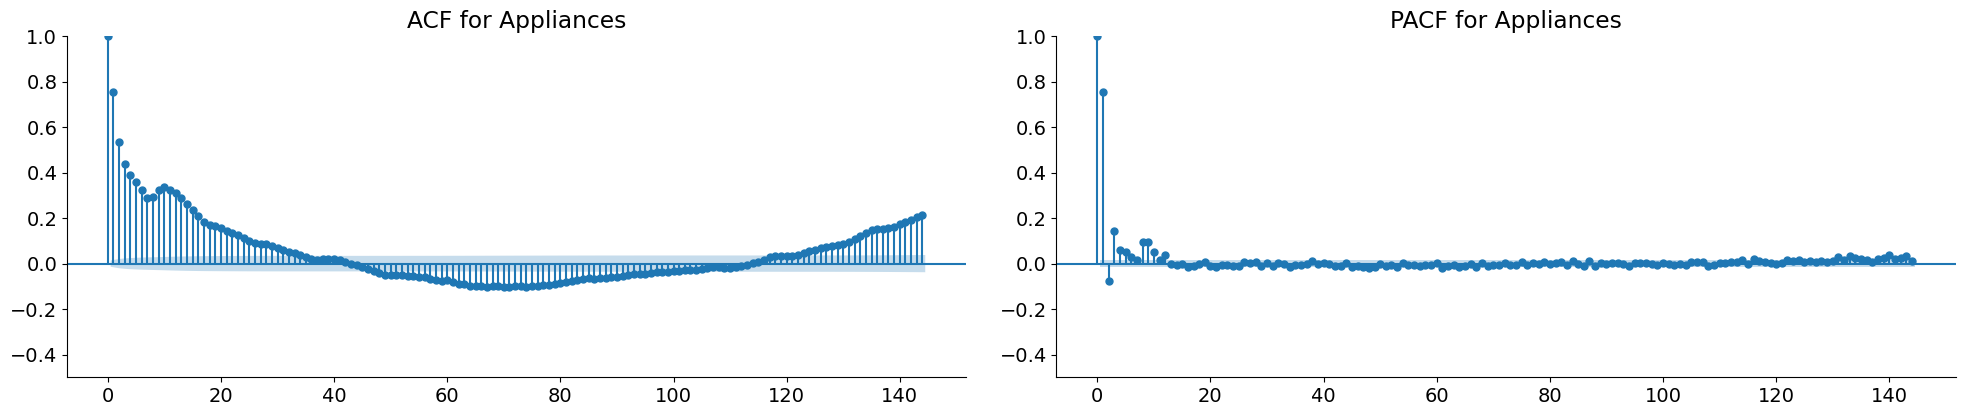

In [29]:
autocorrelation_plot(data.Appliances, 144)

## Energy consumption in smaller periods

At this stage, certain datetime features were added that can be helpful for further analysis.

In [36]:
enhancer = DataEnhancer(data)
enhanced_data = enhancer.add_datetime_features().data

enhanced_data.iloc[:,-8:].head(3)

,day_of_week,hour,minute,time_of_day,week_of_year,day_of_year,is_holiday,is_weekend
date,,,,,,,,
2016-01-11 17:00:00,Monday,17,0,evening,2,11,0,0
2016-01-11 17:10:00,Monday,17,10,evening,2,11,0,0
2016-01-11 17:20:00,Monday,17,20,evening,2,11,0,0


**The heatmap below** displays the hourly average appliance usage for weekdays, while on the right side, the average total daily demands for weekdays are visible. The chart reflects, to some extent, the weekly routine of the residents. It can be observed that at certain hours, consumption is significantly higher than at others, just as there are days with lower and higher demand. It appears that in the middle of the day, especially from 11 AM to 4 PM, consumption is relatively lower on some days, while the highest usage occurs in the early evening hours. However, this pattern changes on days with the highest consumption.


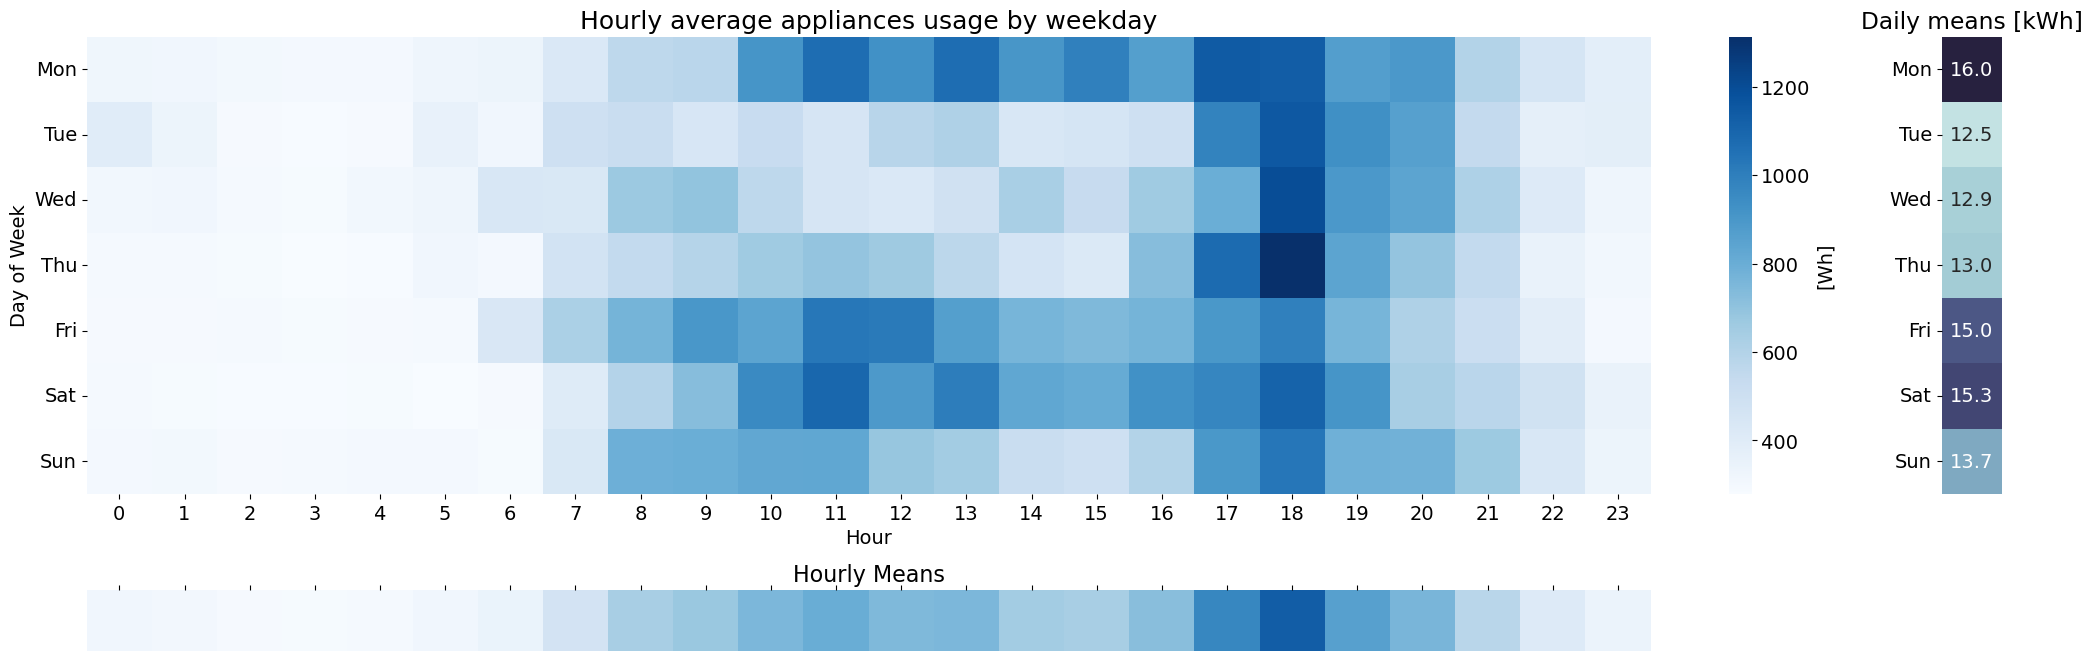

In [6]:
consumption_by_day_and_hour(enhanced_data[["Appliances", "week_of_year", "day_of_week", "hour"]])

### Exploring data by weeks

In [7]:
visualizer = WeeklyDataVisualizer(enhanced_data)

Though the total or average energy consumption indicates seasonality depending on the time of day and day of the week, an examination of individual weeks reveals significant variability in both the hourly demand values and their distribution throughout the day and week. This variability is consistent with the quantity and range of residuals observed in the decomposition. Consequently, the accuracy of predictions will heavily rely on the input variables and how effectively they relate to appliance energy consumption.

Two example different weeks are depicted below.

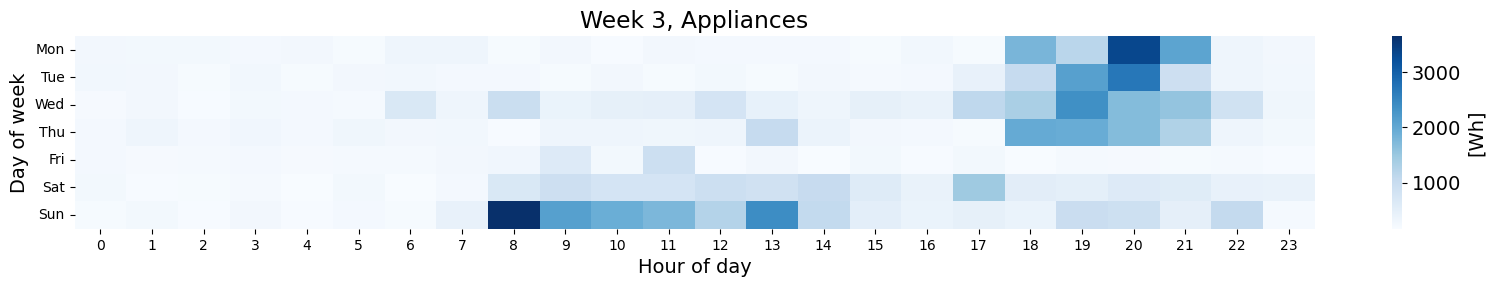

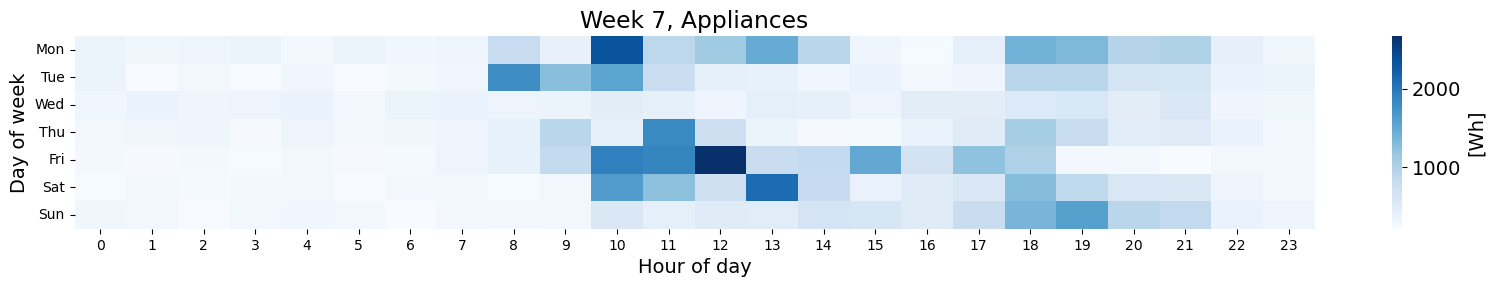

In [14]:
visualizer.plot_heatmap([3, 7], "Appliances")

As mentioned before, several days/periods were observed during which there is likely no one at home or presence is significantly limited. This is even more apparent when the data is broken down by weeks - as can be seen below, particularly on January 28-29 and April 2-3.

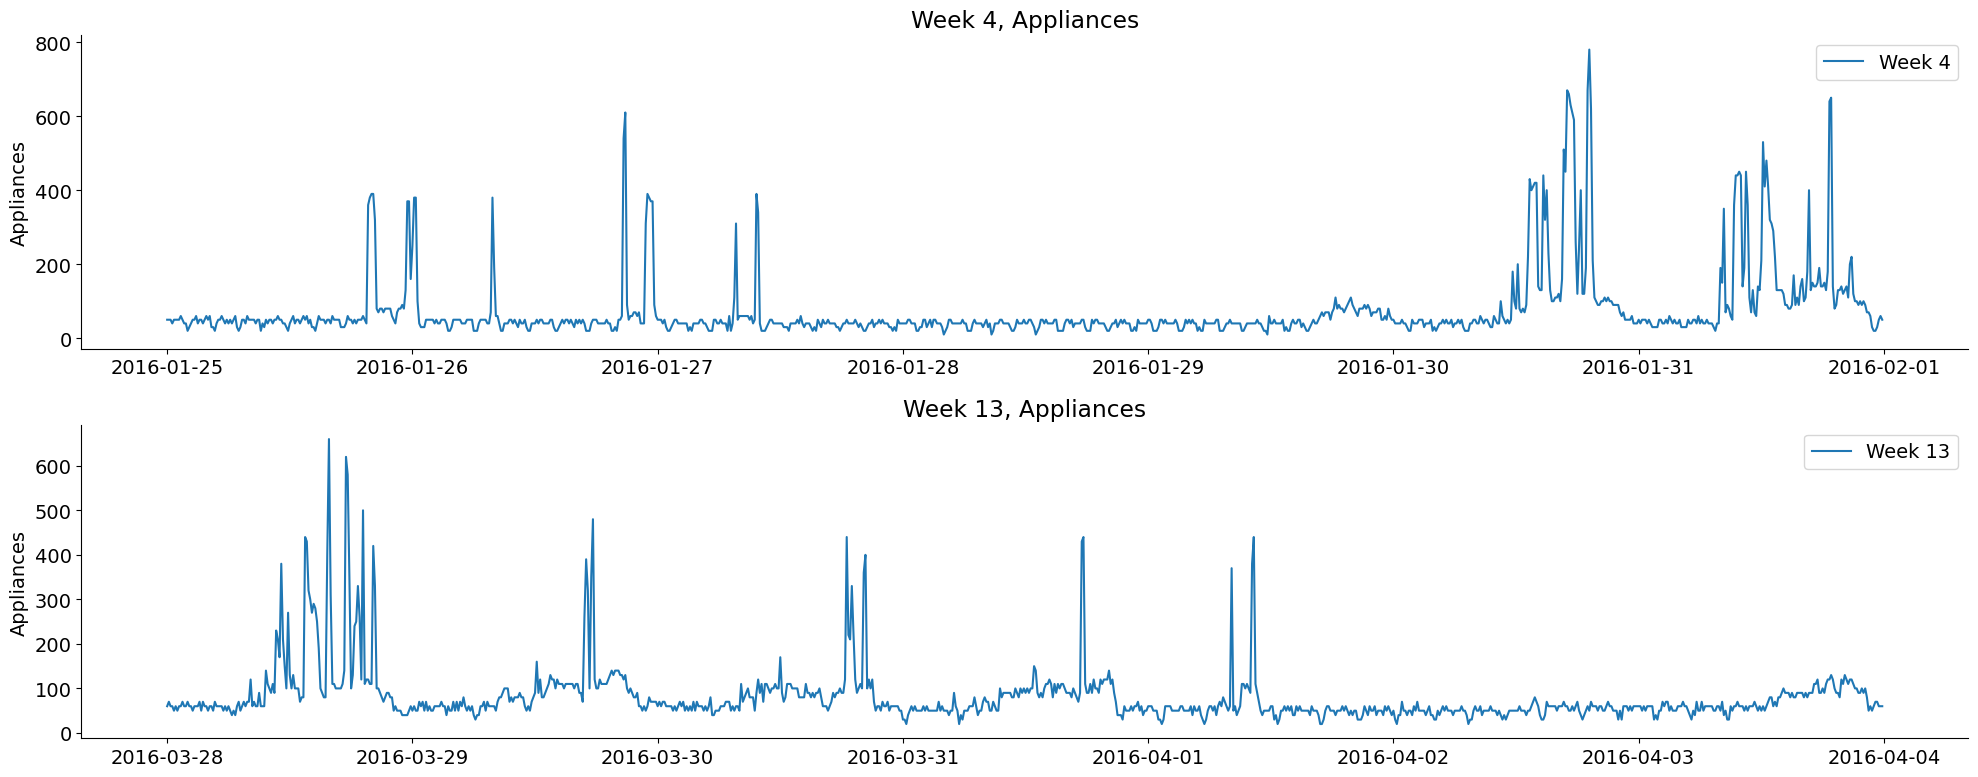

In [74]:
visualizer.plot_many_weeks(weeks=[4, 13], columns=["Appliances"], single_plot=False)

It was assumed that days on which energy consumption remains at a similar low level throughout the day without any noticeable peak, such days will be marked with an additional column. After analyzing the weekly charts and energy consumption values, it was decided that these would be days where the maximum observed value does not exceed 250 Wh (their statistics can be seen below).

In [112]:
grouped = enhanced_data.groupby(enhanced_data.index.date)["Appliances"]
described = grouped.describe().round(2)
described["sum"] = grouped.sum()
described[described["max"] <= 250]

,count,mean,std,min,25%,50%,75%,max,sum
2016-01-28,144.0,37.500000,10.544611,10.0,30.0,40.0,40.0,50.0,5400
2016-01-29,144.0,48.055556,21.098430,10.0,40.0,40.0,60.0,110.0,6920
2016-02-17,144.0,66.805556,22.082261,20.0,50.0,60.0,80.0,180.0,9620
2016-02-28,144.0,53.472222,19.515798,20.0,40.0,50.0,60.0,150.0,7700
2016-03-13,144.0,67.916667,27.197156,30.0,50.0,60.0,70.0,140.0,9780
2016-03-18,144.0,62.638889,31.820873,20.0,50.0,50.0,70.0,250.0,9020
2016-03-27,144.0,73.055556,25.011264,30.0,60.0,70.0,80.0,180.0,10520
2016-04-02,144.0,50.694444,10.880969,20.0,50.0,50.0,60.0,80.0,7300
2016-04-03,144.0,71.805556,23.344569,30.0,60.0,60.0,90.0,130.0,10340
2016-05-20,144.0,64.722222,20.920911,20.0,50.0,60.0,70.0,170.0,9320


These periods are also reflected in the data concerning the home's microclimate, where the typically observed daily fluctuations appear to flatten out - however, these relationships are not entirely clear. Below, week 4 can be seen again, featuring data on temperature and humidity in some rooms.

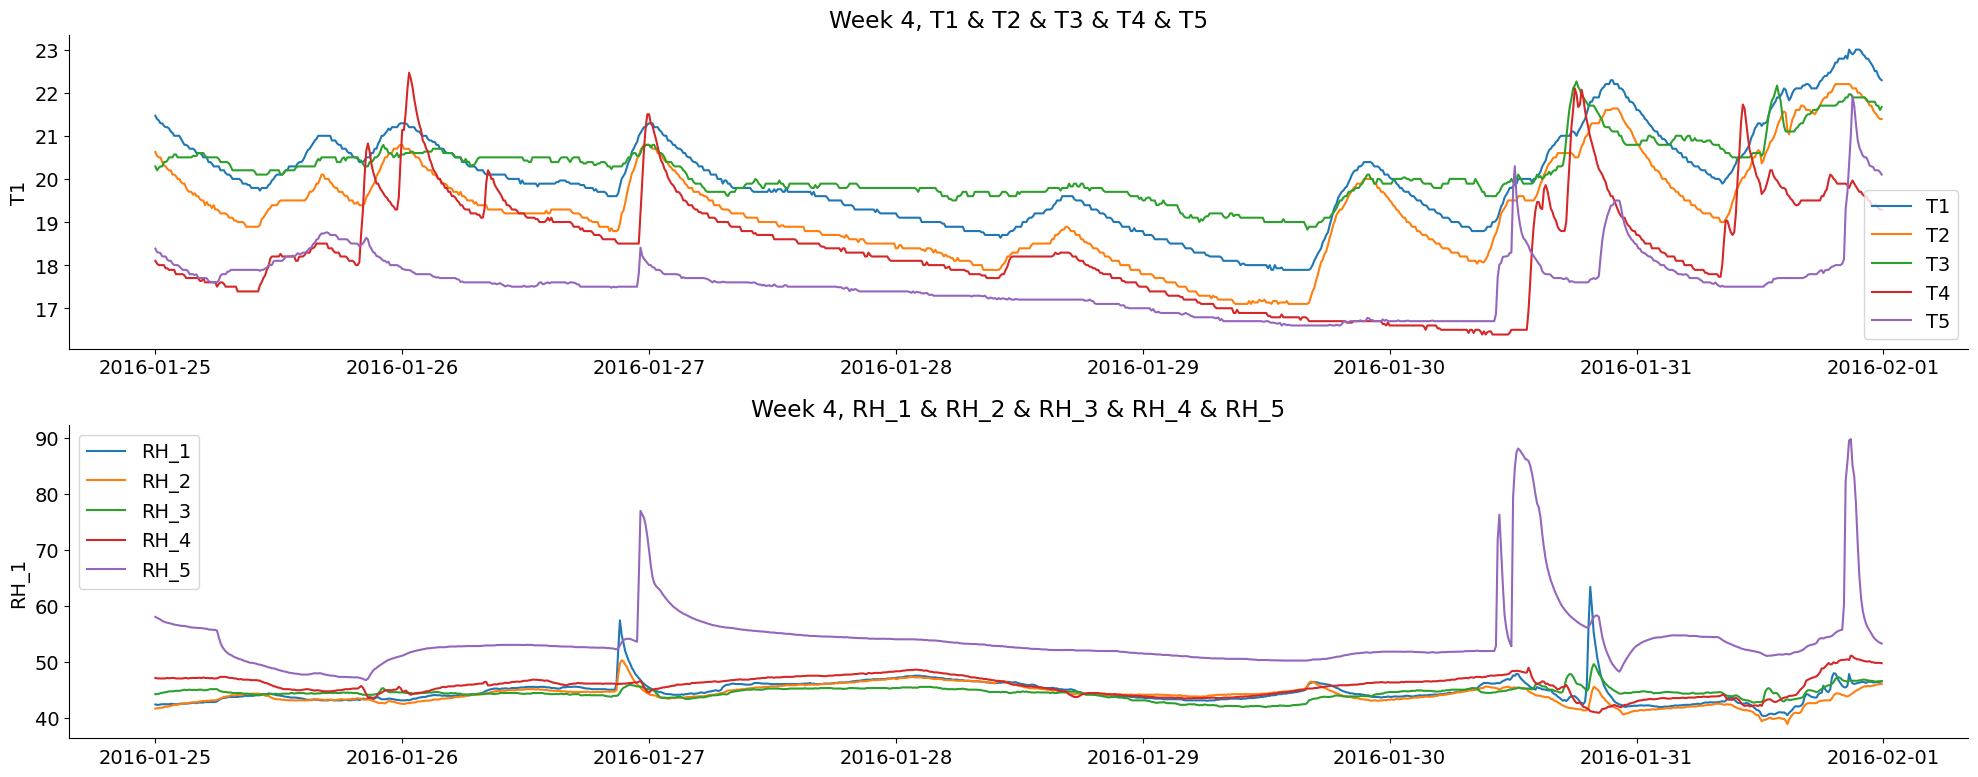

In [92]:
visualizer.plot_one_week(4, columns=[["T1", "T2", "T3", "T4", "T5"],
                                     ["RH_1", "RH_2", "RH_3", "RH_4", "RH_5"]])

To support the aforementioned observations, below are examples of temperature/humidity fluctuations in different rooms (T2 - living room, T5, RH_5 - bathroom) over three consecutive weeks, including week 4 again, when the occupants were absent.

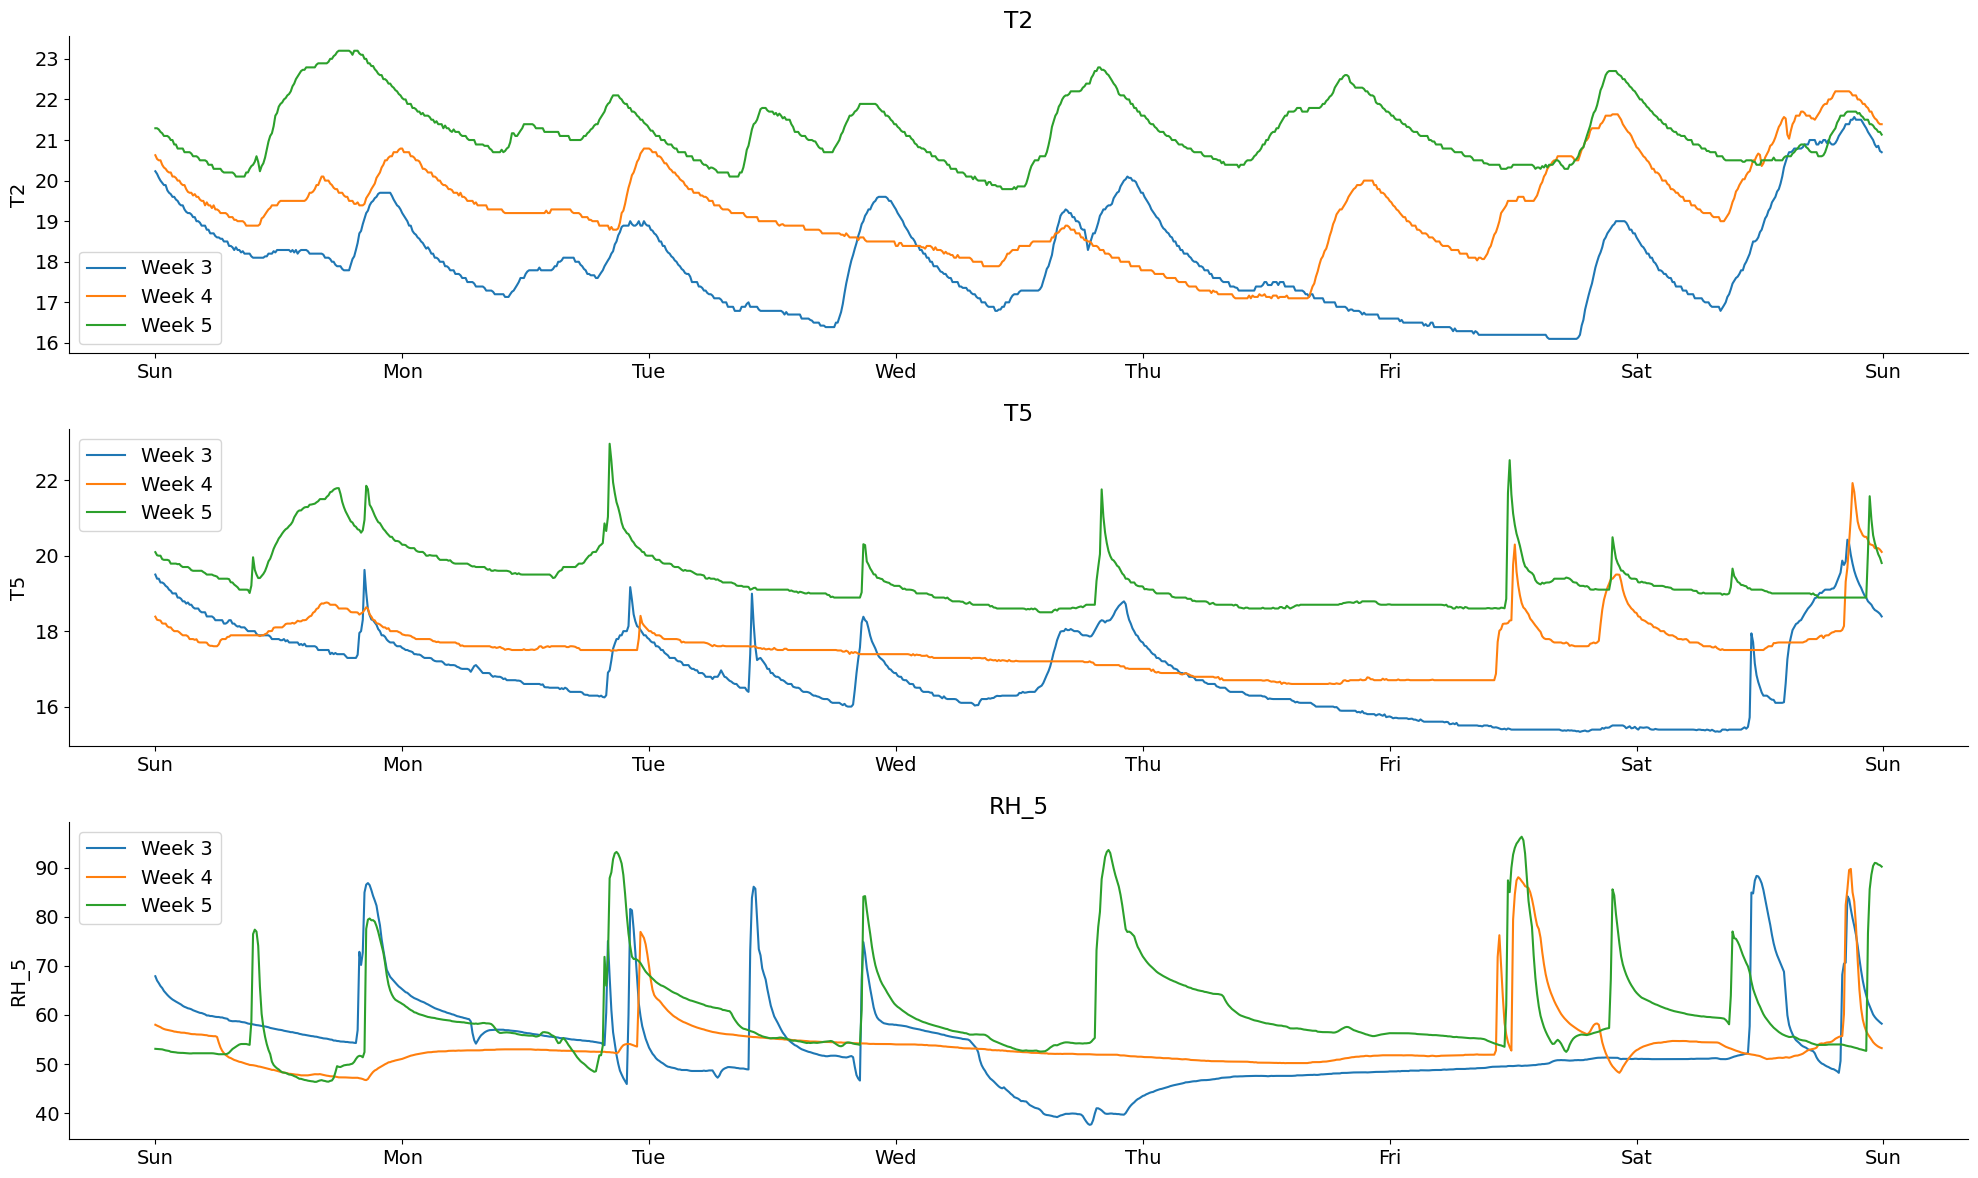

In [117]:
visualizer.plot_many_weeks(weeks=[3, 4, 5], columns=["T2", "T5", "RH_5"])